# STAD68 Final Report - Cats & Dogs Classification
### By:

*   Abu Bakar Al-Hilal
*   Kuei-Sheng Hou
*   Yimo Shen
*   Tianxi Hu



# Data Description and Preparation

## Connect and Load Data using Kaggle API

In [ ]:
# Please upload your Kaggle Token file 'kaggle.json'
# How to get your Kaggle Token: https://christianjmills.com/posts/kaggle-obtain-api-key-tutorial/

# Uploading your Kaggle Toekn using Google Colab Function
from google.colab import files
files.upload()

In [ ]:
!pip install kaggle

In [ ]:
# downlaod data using Kaggle API
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/
! kaggle competitions download -c dog-vs-cat-classification

# unzip downloaded file
import zipfile
zip_ref = zipfile.ZipFile('dog-vs-cat-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Preprocessing

+ First we want to find the max x, y dimentions and min x, y dimentions

+ The max x is 1050 and max y is 768
+ The min x is 42 and min y is 31

In [ ]:
import os
import glob
from PIL import Image

# Path to your dataset
cats_dir = 'train/train/cats'
dogs_dir = 'train/train/dogs'

# Collect all image file paths
cat_images = glob.glob(os.path.join(cats_dir, '*.jpg'))
dog_images = glob.glob(os.path.join(dogs_dir, '*.jpg'))

all_images = cat_images + dog_images

max_width, max_height = 0, 0
min_width, min_height = 10000, 10000

for img_path in all_images:
    with Image.open(img_path) as img:
        width, height = img.size
        # find max length and width
        if width > max_width:
            max_width = width
        if height > max_height:
            max_height = height
        # find mmin length and width
        if width < min_width:
            min_width = width
        if height < min_height:
            min_height = height

print(f"Max width: {max_width}")
print(f"Max height: {max_height}")
print(f"Min width: {min_width}")
print(f"Min height: {min_height}")

Max width: 1050
Max height: 768
Min width: 42
Min height: 32


+ Normalize the images between 0 and 1
+ Split the data into 80% training and 20% Testing
+ From the output below, each class have equal number of images, so we have a balanced dataset

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

TRAIN_DIR = './train/train'
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

dir_path_cat = './train/train/cats'
dir_path_dog = './train/train/dogs'
cat_count = 0
dog_count = 0

# count number of cats images
for path in os.listdir(dir_path_cat):
    if os.path.isfile(os.path.join(dir_path_cat, path)):
        cat_count += 1
print('cat count:', cat_count)

# count number of dogs images
for path in os.listdir(dir_path_dog):
    if os.path.isfile(os.path.join(dir_path_dog, path)):
        dog_count += 1
print('dog count:', dog_count)

# rescale images
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data
valid_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

cat count: 12500
dog count: 12500
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Data integrity check

In [ ]:
import tensorflow as tf
import os

def remove_corrupted_images(directory):
    num_deleted = 0
    for folder_name in ["cats", "dogs"]:
        folder_path = os.path.join(directory, folder_name)
        for filename in os.listdir(folder_path):
            filepath = os.path.join(folder_path, filename)
            try:
                img_bytes = open(filepath, 'rb').read()
                tf.io.decode_jpeg(img_bytes)
            except:
                num_deleted += 1
                os.remove(filepath)
    print(f"Removed {num_deleted} corrupted images.")

remove_corrupted_images(TRAIN_DIR)

Removed 0 corrupted images.


Let's look at the first 4 images in our training data

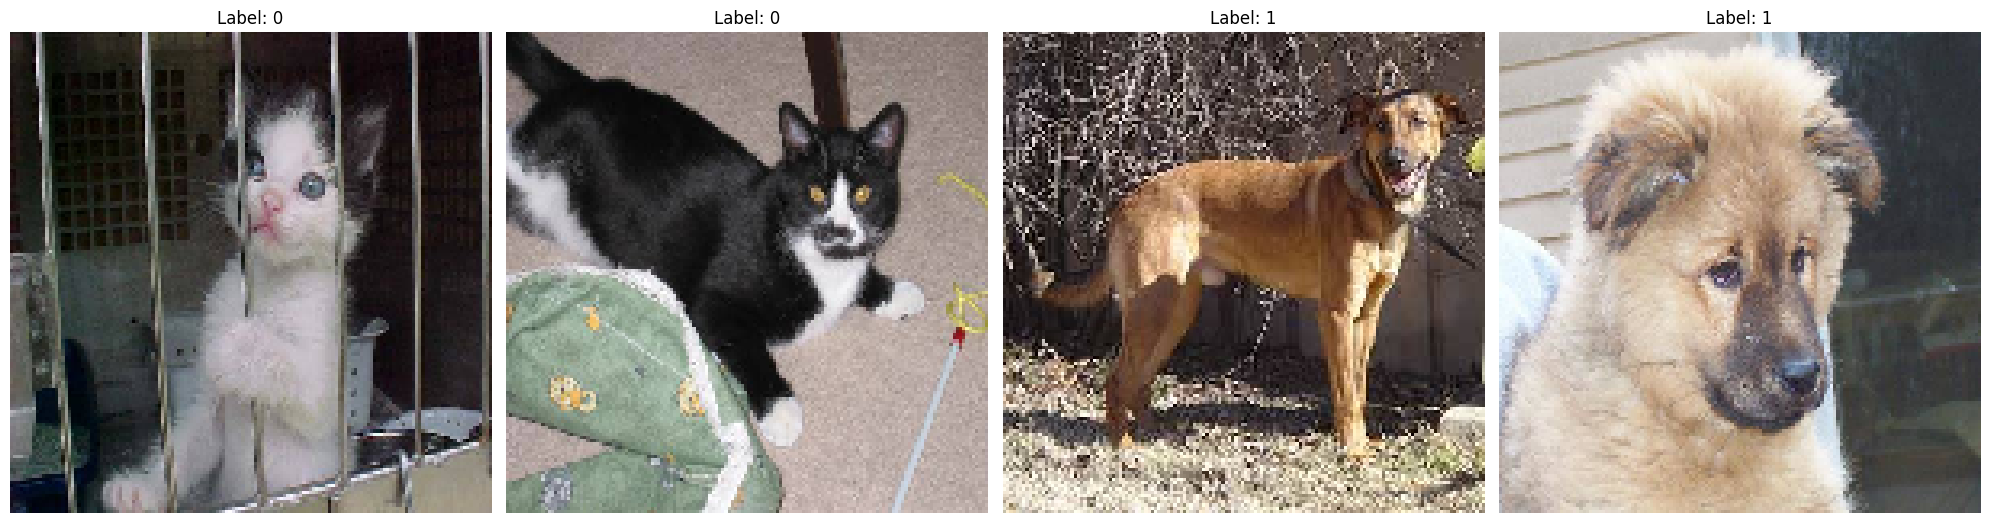

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# get a batch of images and labels
images, labels = next(train_generator)

# define class labels (assuming cats is class 0 and dogs is class 1)
class_names = list(train_generator.class_indices.keys())

fig, axes = plt.subplots(1, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f"Label: {int(labels[i])}")

plt.tight_layout()
plt.show()


From the images above, our Cats is label as 0, Dogs is label as 1.

# Model Training and Evaluation

## Basic CNN - 97% Accuracy on Kaggle


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Basic CNN
def create_basic_cnn(input_shape=(150, 150, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate the model
basic_cnn = create_basic_cnn(input_shape=(150, 150, 3))

# Compile the model
basic_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show model summary
basic_cnn.summary()

# Train the model
EPOCHS = 10
basic_cnn_history = basic_cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS
)

# Evaluate on validation set
val_loss, val_acc = basic_cnn.evaluate(valid_generator, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.6118 - loss: 0.6419 - val_accuracy: 0.7410 - val_loss: 0.5245
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - accuracy: 0.7819 - loss: 0.4581 - val_accuracy: 0.7968 - val_loss: 0.4367
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.8318 - loss: 0.3784 - val_accuracy: 0.8240 - val_loss: 0.3825
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.8800 - loss: 0.2871 - val_accuracy: 0.8240 - val_loss: 0.3823
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 73ms/step - accuracy: 0.9118 - loss: 0.2127 - val_accuracy: 0.8390 - val_loss: 0.4043
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9518 - loss: 0.1286 - val_accuracy: 0.8366 - val_loss: 0.4580
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9754 - loss: 0.0695 - val_accuracy: 0.8368 - val_loss: 0.6016
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.9864 - loss: 0.0432 - 

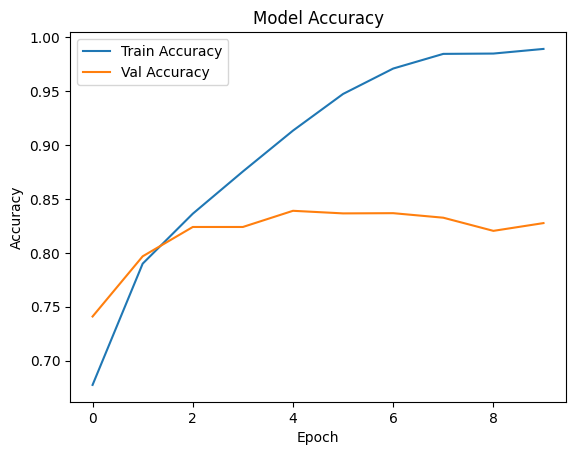

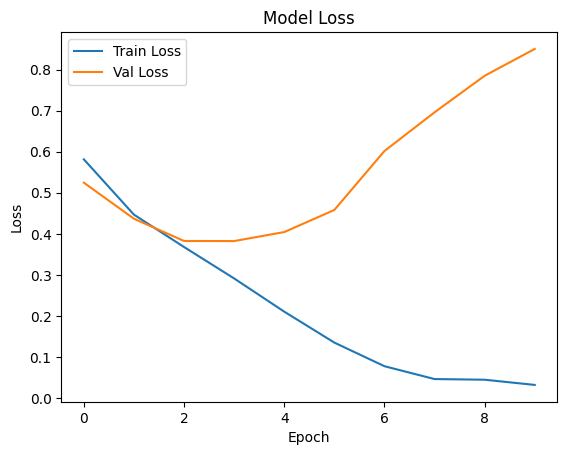

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(basic_cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(basic_cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(basic_cnn_history.history['loss'], label='Train Loss')
plt.plot(basic_cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

For the Basic CNN Model above, we have 97% accuracy from Kaggle. However, from the performance plot, there are evidence of overfitting.

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step
Confusion matrix:
 [[1982  518]
 [ 344 2156]]


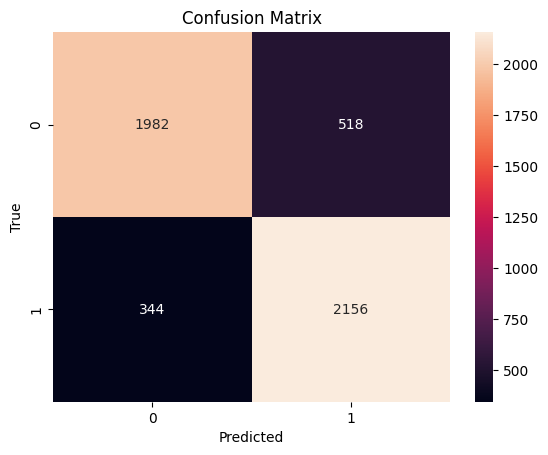

              precision    recall  f1-score   support

         Cat       0.85      0.79      0.82      2500
         Dog       0.81      0.86      0.83      2500

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the model
pred_probs = basic_cnn.predict(valid_generator)
pred_labels = np.where(pred_probs > 0.5, 1, 0).flatten()

# Get true labels from the generator
true_labels = valid_generator.classes

# Build the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion matrix:\n", cm)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=["Cat", "Dog"])
print(report)

## Adjusted Basic CNN to Reduce Overfitting - 86% Accuracy

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Adjusted CNN with Dropout and BatchNormalization
def create_adjusted_cnn(input_shape=(150, 150, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate the adjusted model
adjusted_cnn = create_adjusted_cnn(input_shape=(150, 150, 3))

# Compile the model
adjusted_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

adjusted_cnn.summary()

# Train the model
EPOCHS = 10
adjusted_cnn_history = adjusted_cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS
)

# Evaluate on validation set
val_loss, val_acc = adjusted_cnn.evaluate(valid_generator, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,889 (18.42 MB)

 Trainable params: 4,829,185 (18.42 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.6390 - loss: 1.2026 - val_accuracy: 0.6372 - val_loss: 1.0311
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.7609 - loss: 0.8548 - val_accuracy: 0.7426 - val_loss: 0.8164
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.7919 - loss: 0.7643 - val_accuracy: 0.6246 - val_loss: 1.1036
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8086 - loss: 0.7664 - val_accuracy: 0.5806 - val_loss: 1.3057
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8250 - loss: 0.7718 - val_accuracy: 0.7280 - val_loss: 0.9493
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8317 - loss: 0.8160 - val_accuracy: 0.8244 - val_loss: 0.8259
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8500 - loss: 0.7851 - val_accuracy: 0.5814 - val_loss: 1.3710
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8564 - loss: 0.7827 - 

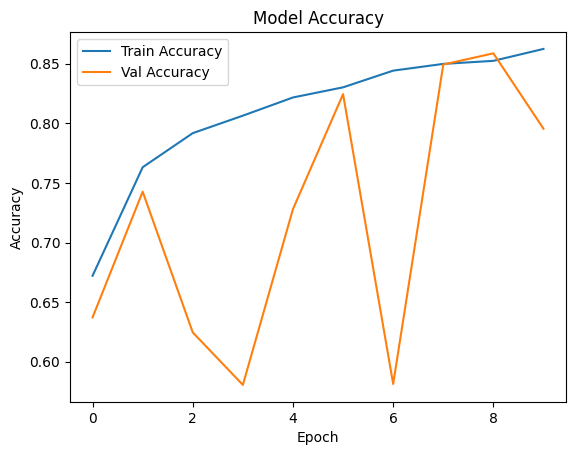

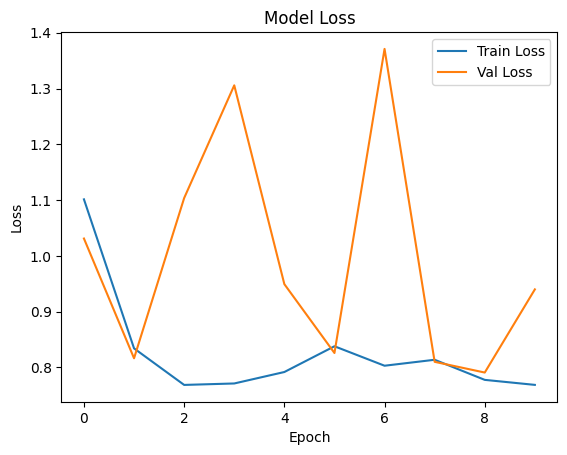

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(adjusted_cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(adjusted_cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(adjusted_cnn_history.history['loss'], label='Train Loss')
plt.plot(adjusted_cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



We successfully reduced overfitting by adding Bach Normalization, Dropouts, and reduced learning rate.

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step
Confusion matrix:
 [[2395  105]
 [1010 1490]]


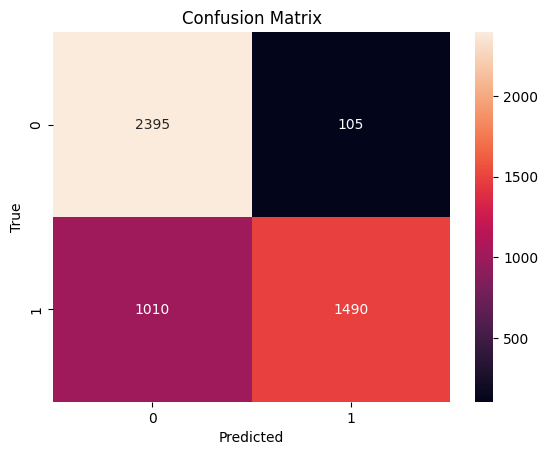

              precision    recall  f1-score   support

         Cat       0.70      0.96      0.81      2500
         Dog       0.93      0.60      0.73      2500

    accuracy                           0.78      5000
   macro avg       0.82      0.78      0.77      5000
weighted avg       0.82      0.78      0.77      5000



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the model
pred_probs = adjusted_cnn.predict(valid_generator)
pred_labels = np.where(pred_probs > 0.5, 1, 0).flatten()

# Get true labels from the generator
true_labels = valid_generator.classes

# Build the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion matrix:\n", cm)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=["Cat", "Dog"])
print(report)

## Deeper CNN - 92% Accuracy on Kaggle

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

X_input = layers.Input((150, 150, 3))

# First Convolutional Block
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X_input)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.MaxPooling2D((2, 2))(X)

# Second Convolutional Block
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.MaxPooling2D((2, 2))(X)

# Third Convolutional Block
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.MaxPooling2D((2, 2))(X)

# Fourth Convolutional Block
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)

X = layers.Flatten()(X)

X = layers.Dense(128, activation='relu')(X)

X = layers.Dense(10)(X)
X = layers.Dense(1, activation='sigmoid')(X)
model_deep = models.Model(inputs=X_input, outputs=X, name="Deep_CNN_Model")


# Loss Function
loss_fn = tf.keras.losses.BinaryCrossentropy()

model_deep.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss_fn,
    metrics=['binary_accuracy'],
)

# Training
EPOCHS = 10
deep_history = model_deep.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS
)

# Evaluate on validation set
val_loss, val_acc = model_deep.evaluate(valid_generator, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 137ms/step - binary_accuracy: 0.5185 - loss: 0.6880 - val_binary_accuracy: 0.6258 - val_loss: 0.6433
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - binary_accuracy: 0.6666 - loss: 0.5975 - val_binary_accuracy: 0.7158 - val_loss: 0.5506
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 135ms/step - binary_accuracy: 0.7213 - loss: 0.5377 - val_binary_accuracy: 0.7746 - val_loss: 0.4698
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 140ms/step - binary_accuracy: 0.7741 - loss: 0.4683 - val_binary_accuracy: 0.8056 - val_loss: 0.4140
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - binary_accuracy: 0.8125 - loss: 0.4006 - val_binary_accuracy: 0.8292 - val_loss: 0.3745
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 137ms/step - binary_accuracy: 0.8403 - loss: 0.3498 - val_binary_accuracy: 0.8432 - val_loss: 0.3480
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 137ms/step - binary_accuracy: 0.8584 - loss: 0.3134 - val_binary_accuracy: 0.8440 - va

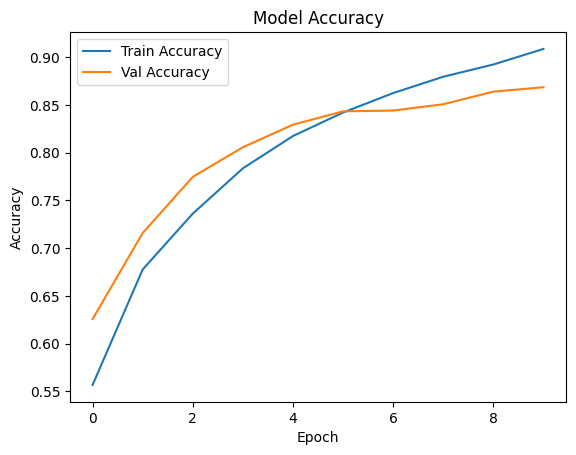

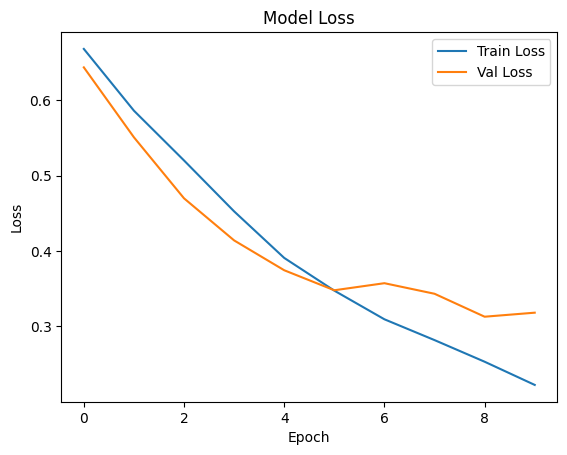

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(deep_history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(deep_history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(deep_history.history['loss'], label='Train Loss')
plt.plot(deep_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step
Confusion matrix:
 [[2092  408]
 [ 250 2250]]


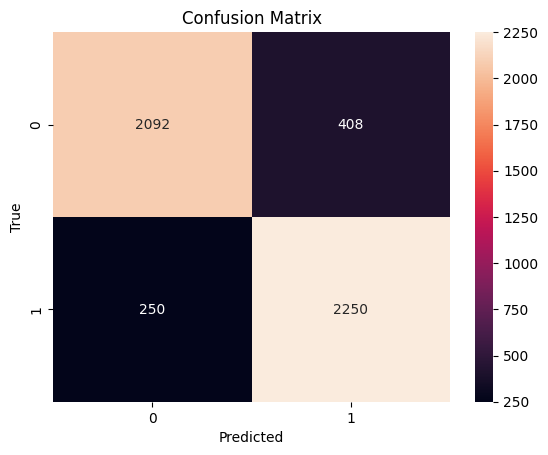

              precision    recall  f1-score   support

         Cat       0.89      0.84      0.86      2500
         Dog       0.85      0.90      0.87      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the model
pred_probs = model_deep.predict(valid_generator)
pred_labels = np.where(pred_probs > 0.5, 1, 0).flatten()

# Get true labels from the generator
true_labels = valid_generator.classes

# Build the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion matrix:\n", cm)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=["Cat", "Dog"])
print(report)

## Deep CNN with Skip Connections (Residual Network) - 97% Accuracy on Kaggle

In [ ]:
X_input = layers.Input((150,150,3))

# # First Convolutional Block
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X_input)
X_branch1 = X

X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Add()([X, X_branch1])
X = layers.MaxPooling2D((2, 2))(X)

# # Second Convolutional Block
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X_branch2 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Add()([X, X_branch2])
X = layers.MaxPooling2D((2, 2))(X)

# Third Convolutional Block
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X_branch3 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Add()([X, X_branch3])
X = layers.MaxPooling2D((2, 2))(X)

# Fourth Convolutional Block
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X_branch4 = X
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Add()([X, X_branch4])

X = layers.Flatten()(X)

X = layers.Dense(128, activation='relu')(X)
X = layers.Dense(10)(X)
X = layers.Dense(1, activation='sigmoid')(X)
model_deep_resnet = models.Model(inputs=X_input, outputs=X, name="Deep_CNN_Model_resnet")


# Loss Function
loss_fn = tf.keras.losses.BinaryCrossentropy()

model_deep_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss_fn,
    metrics=['accuracy'],
)

# Training
EPOCHS = 10
deep_resnet_history = model_deep_resnet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS
)

# Evaluate on validation set
val_loss, val_acc = model_deep.evaluate(valid_generator, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")



Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 135ms/step - accuracy: 0.5777 - loss: 0.6591 - val_accuracy: 0.7324 - val_loss: 0.5363
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.7475 - loss: 0.5066 - val_accuracy: 0.7818 - val_loss: 0.4664
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.8027 - loss: 0.4298 - val_accuracy: 0.8226 - val_loss: 0.3851
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.8423 - loss: 0.3555 - val_accuracy: 0.8468 - val_loss: 0.3481
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.8686 - loss: 0.3073 - val_accuracy: 0.8562 - val_loss: 0.3185
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - accuracy: 0.8935 - loss: 0.2556 - val_accuracy: 0.8216 - val_loss: 0.4183
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 138ms/step - accuracy: 0.9104 - loss: 0.2133 - val_accuracy: 0.8950 - val_loss: 0.2538
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.9283 - loss: 

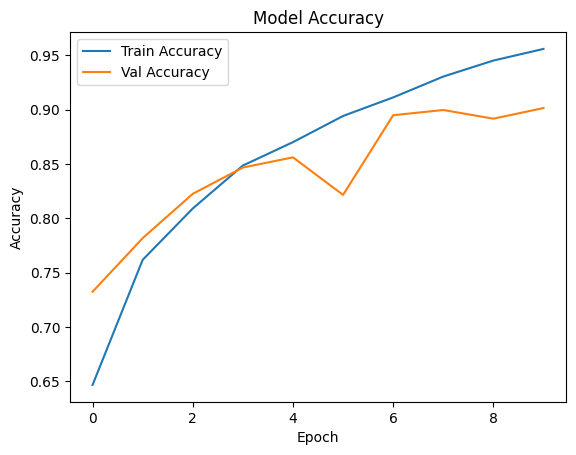

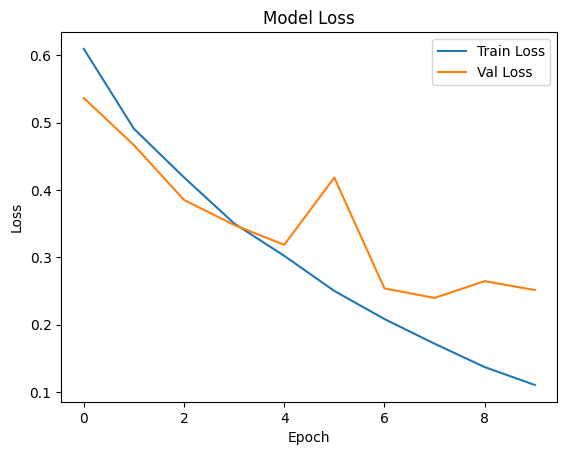

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(deep_resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(deep_resnet_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(deep_resnet_history.history['loss'], label='Train Loss')
plt.plot(deep_resnet_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step
Confusion matrix:
 [[2223  277]
 [ 215 2285]]


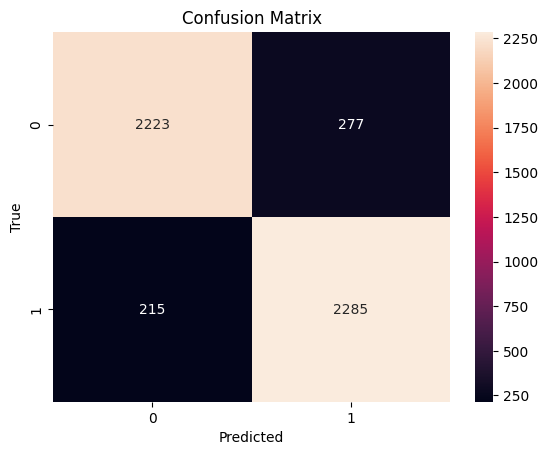

              precision    recall  f1-score   support

         Cat       0.91      0.89      0.90      2500
         Dog       0.89      0.91      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the model
pred_probs = model_deep_resnet.predict(valid_generator)
pred_labels = np.where(pred_probs > 0.5, 1, 0).flatten()

# Get true labels from the generator
true_labels = valid_generator.classes

# Build the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion matrix:\n", cm)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=["Cat", "Dog"])
print(report)

## VGG16 Transfer Learning - 97% Accuracy on Kaggle
### Input Size 150 * 150 with 10 Epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
import os

# Paths
train_dir = "train/train"
# Basic training parameters
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

# Load VGG16 base (no top layers), using ImageNet weights
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze all layers in the base model so they do NOT update during initial training
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()


model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # helps reduce overfitting
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_vgg.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
import os

# Paths
train_dir = "train/train"
# Basic training parameters
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

# Load VGG16 base (no top layers), using ImageNet weights
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze all layers in the base model so they do NOT update during initial training
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()


model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # helps reduce overfitting
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_vgg.summary()

In [ ]:

EPOCHS = 10

vgg_history = model_vgg.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator
)

Epoch 1/10
625/625 [==============================] - 14s 22ms/step - loss: 0.3138 - accuracy: 0.8679 - val_loss: 0.2277 - val_accuracy: 0.9048
Epoch 2/10
625/625 [==============================] - 15s 24ms/step - loss: 0.2363 - accuracy: 0.8984 - val_loss: 0.2245 - val_accuracy: 0.9032
Epoch 3/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2088 - accuracy: 0.9110 - val_loss: 0.2233 - val_accuracy: 0.9038
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 0.1925 - accuracy: 0.9189 - val_loss: 0.2359 - val_accuracy: 0.9008
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.1767 - accuracy: 0.9254 - val_loss: 0.2112 - val_accuracy: 0.9114
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.1669 - accuracy: 0.9305 - val_loss: 0.2114 - val_accuracy: 0.9130
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 0.1577 - accuracy: 0.9354 - val_loss: 0.2241 - val_accuracy:

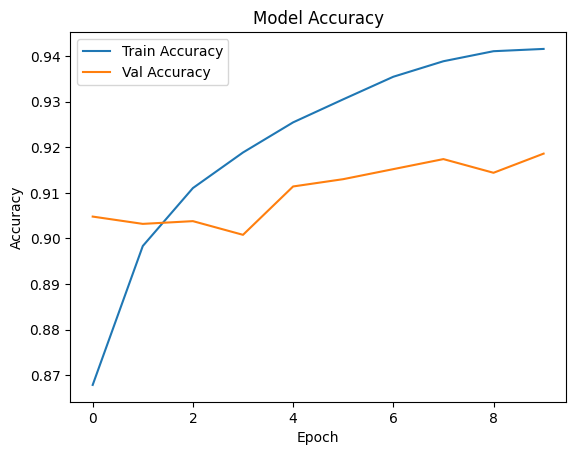

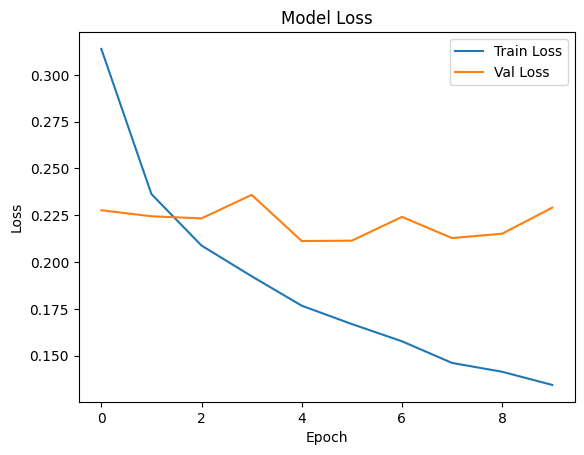

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step
Confusion matrix:
 [[2268  232]
 [ 183 2317]]


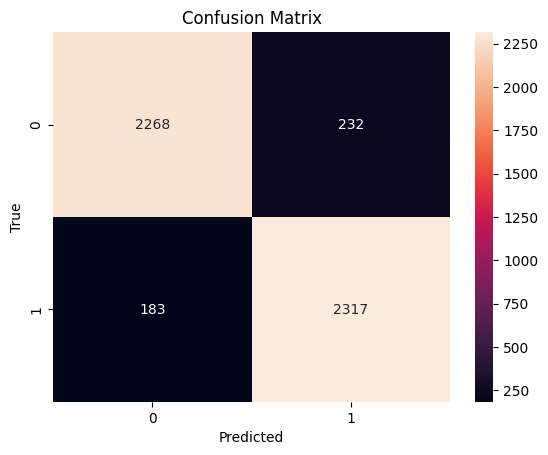

              precision    recall  f1-score   support

         Cat       0.93      0.91      0.92      2500
         Dog       0.91      0.93      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the model
pred_probs = model_vgg.predict(valid_generator)
pred_labels = np.where(pred_probs > 0.5, 1, 0).flatten()

# Get true labels from the generator
true_labels = valid_generator.classes

# Build the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion matrix:\n", cm)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=["Cat", "Dog"])
print(report)


## Futher experiment with different Input Sizes on VGG16

### Input Size 224 * 224 with 10 Epochs

In [ ]:
tf.random.set_seed(42)

TRAIN_DIR = './train/train'
BATCH_SIZE = 32
IMG_SIZE_VGG = (224, 224)              #trying its default size

dir_path_cat = './train/train/cats'
dir_path_dog = './train/train/dogs'
cat_count = 0
dog_count = 0

# count number of cats images
for path in os.listdir(dir_path_cat):
    if os.path.isfile(os.path.join(dir_path_cat, path)):
        cat_count += 1
print('cat count:', cat_count)

# count number of dogs images
for path in os.listdir(dir_path_dog):
    if os.path.isfile(os.path.join(dir_path_dog, path)):
        dog_count += 1
print('dog count:', dog_count)

# rescale images
datagen_vgg = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data
train_generator_vgg = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data
valid_generator_vgg = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

cat count: 12500
dog count: 12500
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
import os

# Paths
train_dir = "train/train"
# Basic training parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Load VGG16 base (no top layers), using ImageNet weights
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers in the base model so they do NOT update during initial training
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()


model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # helps reduce overfitting
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_vgg.summary()

EPOCHS = 10

vgg_history = model_vgg.fit(
    train_generator_vgg,
    epochs=EPOCHS,
    validation_data=valid_generator_vgg
)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

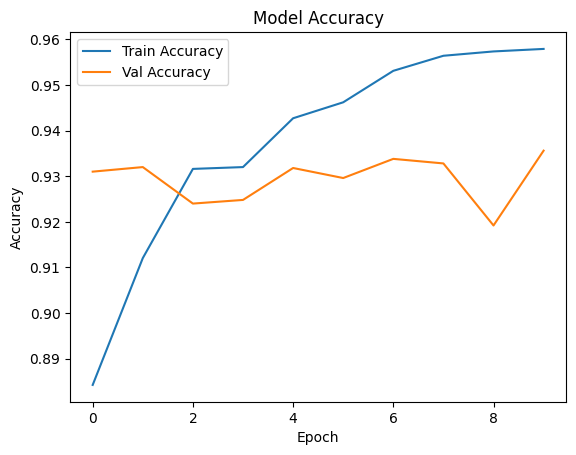

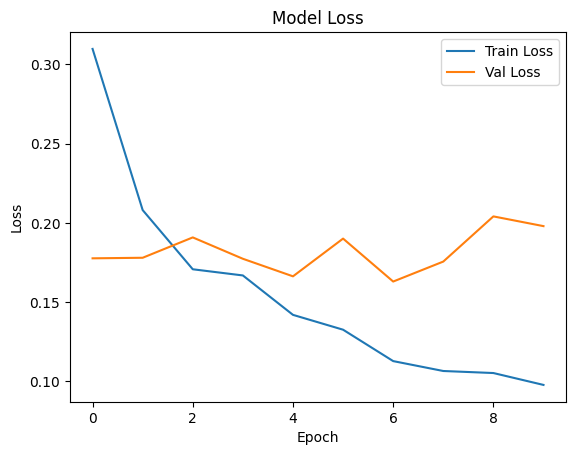

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Input Size 500 * 500 with 10 Epochs

In [ ]:
tf.random.set_seed(42)

TRAIN_DIR = './train/train'
BATCH_SIZE = 32
IMG_SIZE_VGG16 = (500, 500)                     #see if higher res does anything

dir_path_cat = './train/train/cats'
dir_path_dog = './train/train/dogs'
cat_count = 0
dog_count = 0

# count number of cats images
for path in os.listdir(dir_path_cat):
    if os.path.isfile(os.path.join(dir_path_cat, path)):
        cat_count += 1
print('cat count:', cat_count)

# count number of dogs images
for path in os.listdir(dir_path_dog):
    if os.path.isfile(os.path.join(dir_path_dog, path)):
        dog_count += 1
print('dog count:', dog_count)

# rescale images
datagen_vgg = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data
train_generator_vgg16 = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_VGG16,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data
valid_generator_vgg16 = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_VGG16,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

cat count: 12500
dog count: 12500
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
import os

# Paths
train_dir = "train/train"
# Basic training parameters
BATCH_SIZE = 32
IMG_SIZE_vgg16 = (500, 500)

# Load VGG16 base (no top layers), using ImageNet weights
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(500, 500, 3)
)

# Freeze all layers in the base model so they do NOT update during initial training
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()


model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # helps reduce overfitting
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_vgg.summary()

EPOCHS = 10

vgg_history = model_vgg.fit(
    train_generator_vgg16,
    epochs=EPOCHS,
    validation_data=valid_generator_vgg16
)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

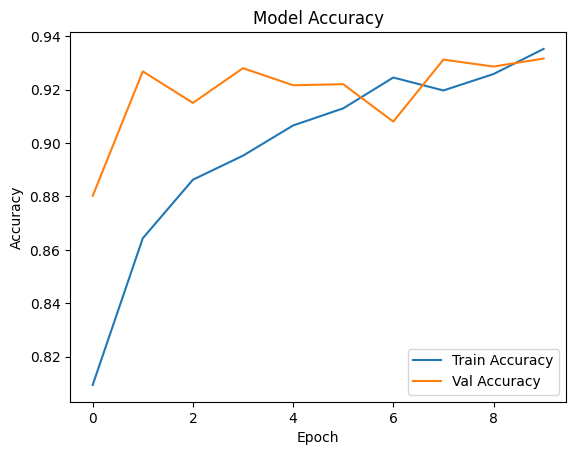

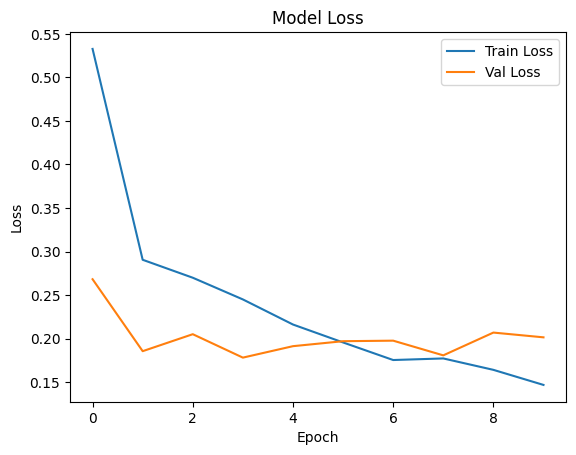

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final Model - VGG16 - 99.5%
### Input Size 224*224
### 30 Epochs

In [ ]:
tf.random.set_seed(42)

TRAIN_DIR = './train/train'
BATCH_SIZE = 32
IMG_SIZE_VGG = (224, 224)              #trying its default size

dir_path_cat = './train/train/cats'
dir_path_dog = './train/train/dogs'
cat_count = 0
dog_count = 0

# count number of cats images
for path in os.listdir(dir_path_cat):
    if os.path.isfile(os.path.join(dir_path_cat, path)):
        cat_count += 1
print('cat count:', cat_count)

# count number of dogs images
for path in os.listdir(dir_path_dog):
    if os.path.isfile(os.path.join(dir_path_dog, path)):
        dog_count += 1
print('dog count:', dog_count)

# rescale images
datagen_vgg = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data
train_generator_vgg = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data
valid_generator_vgg = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

cat count: 12500
dog count: 12500
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
import os

# Paths
train_dir = "train/train"
# Basic training parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Load VGG16 base (no top layers), using ImageNet weights
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers in the base model so they do NOT update during initial training
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()


model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # helps reduce overfitting
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_vgg.summary()

EPOCHS = 30

vgg_history = model_vgg.fit(
    train_generator_vgg,
    epochs=EPOCHS,
    validation_data=valid_generator_vgg
)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

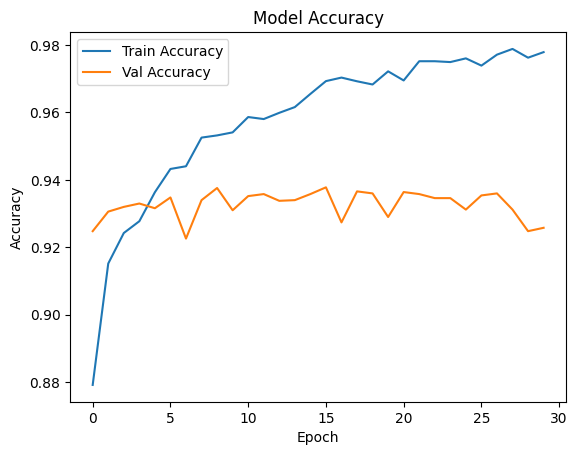

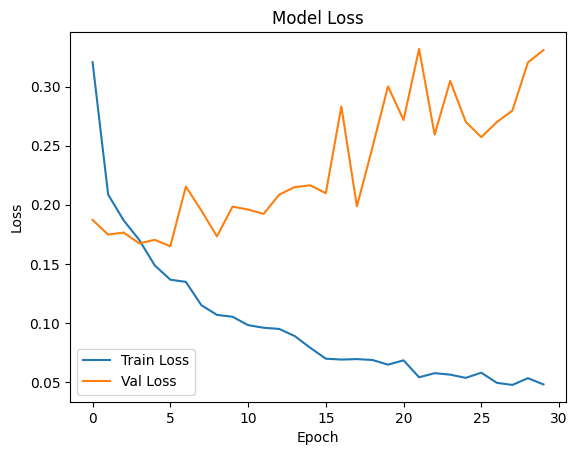

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Loading Testing Data and Making Prediction

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "test/test",
    labels=None,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 8000 files.


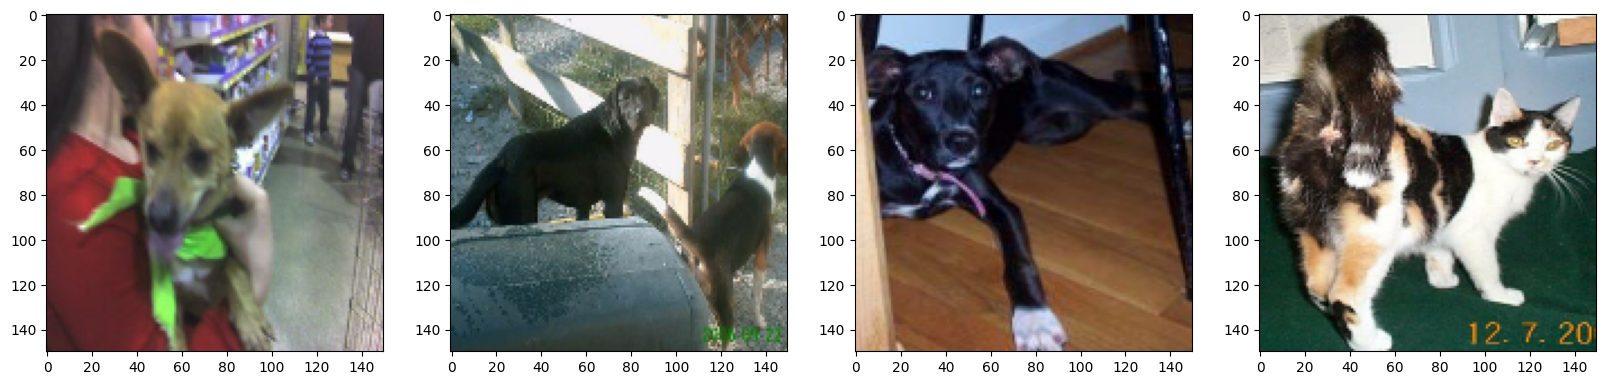

In [ ]:
test_dataset_iterator = test_dataset.as_numpy_iterator()
test_batch = test_dataset_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(test_batch[:4]):
    ax[idx].imshow(img.astype(int))


In [ ]:
test_dataset = test_dataset.map(lambda x: (x/255))

In [ ]:
predictions = model_vgg.predict(test_dataset)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()
print(predicted_classes)


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
[1 1 1 ... 1 1 0]


In [ ]:
import os
%pip install pandas

test_dir = "test/test"
file_names = sorted(os.listdir(test_dir))
print(file_names)

import pandas as pd
submission_df = pd.DataFrame({
    'id':    file_names,
    'labels': predicted_classes
})

submission_df.to_csv('cat_dog_submission.csv', index=False)
print("Submission file saved: cat_dog_submission.csv")


['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '0000

# Submit Prediction using Kaggle API

In [ ]:
!kaggle competitions submit -c dog-vs-cat-classification -f cat_dog_submission.csv -m "Message"

100% 102k/102k [00:00<00:00, 161kB/s]
Successfully submitted to Dog vs Cat classification